# Gender Analysis on CMU Movie Dataset

As feminist consciousness grows, more people start to wonder if gender stereotypes exist and where they occur. We would like to examine whether gender stereotypes exist in movies.

What research questions do we want to ask?

## Load the CMU movie dataset

We automatically extract dataset from this [website](http://www.cs.cmu.edu/~ark/personas/data/) and put all movie data at the folder `data/MovieSummaries/` and put plot summaries processed by CoreNLP at the folder `data/CoreNLP/`.

In [1]:
import os
import re
import math
import gzip
import urllib
import string
import tarfile
import requests
import collections
import pandas as pd
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
%matplotlib inline

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path+"corenlp_plot_summaries/"
summary_path = corenlp_path+"corenlp_plot_summaries_xml/"
movies_path = cmu_path+"movie.metadata.tsv"
characters_path = cmu_path+"character.metadata.tsv"
plot_path = cmu_path+"plot_summaries.txt"

In [3]:
if not os.path.exists(movies_path):
    movie_url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz") 
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [4]:
if not os.path.exists(corenlp_path):
    corenlp_url = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|") 
    tar_file.extractall(path=corenlp_path)
    
    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename) 
        if os.path.isfile(f):
            with gzip.open(f, 'rb') as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], 'wb') as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [5]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres"
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id"
]

plot_column_names = ['wikipedia_id', 'summary']

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)
plots = pd.read_csv(plot_path, sep='\t', header=None, names=plot_column_names)

In [6]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `name`: Movie name
- `release_date`: Movie release date
- `box_office_revenue`: Movie box office revenue
- `runtime`: Movie runtime (in minutes)
- `languages`: Movie languages (Freebase ID:name tuples)
- `countries`: Movie countries (Freebase ID:name tuples)
- `genres`: Movie genres (Freebase ID:name tuples)

In [7]:
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `release_date`: Movie release date
- `character_name`: Character name
- `actor_dob`: Actor date of birth
- `actor_gender`: Actor gender
- `actor_height`: Actor height (in meters)
- `actor_ethnicity`: Actor ethnicity (Freebase ID)
- `actor_name`: Actor name
- `actor_age`:Actor age at movie release
- `freebase_character_map`: Freebase character/actor map ID
- `freebase_character_id`: Freebase character ID
- `freebase_actor_id`: Freebase actor ID

In [8]:
plots.head()

,wikipedia_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Attributes:

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

The plot summaries are processed by CoreNLP pipeline (tagging, parsing, NER, and coref). The data are in the folder `data/CoreNLP/corenlp_plot_summaries_xml/*`. Each filename begins with the Wikipedia movie ID (which indexes into dataframe `movies`) and ends with the format `.xml`.

## Glance at the data and data preprocessing

### Missing values

First we glance at the data and see how many null values in the dataset.

#### Movies

In [9]:
print('Percentage of NaN values in the movie dataset (total {} rows):'.format(len(movies)))
print(movies.isna().sum() / len(movies) * 100)

Percentage of NaN values in the movie dataset (total 81741 rows):
wikipedia_id           0.000000
freebase_id            0.000000
name                   0.000000
release_date           8.443743
box_office_revenue    89.722416
runtime               25.018045
languages              0.000000
countries              0.000000
genres                 0.000000
dtype: float64


Almost 90% of box office revenue data are missing, and box office revenue is NOT the aspect we want to study on gender analysis. Besides, about one fourth of movie runtime data are missing, and it is also NOT important for our gender analysis. Therefore, we directly discard these features.

Over 8% of the movie release dates are missing, which we need for gender analysis from a temporal perspective. So it is necessary to keep and properly process this feature. now we just choose to drop rows with null `release_date`.

In [10]:
try:
    movies = movies.drop(columns=[
        'box_office_revenue',
        'runtime'
    ])
except:
    pass

movies = movies.dropna(subset=['release_date'])
print("{} movies left (81741 before).".format(len(movies)))
movies.head()

74839 movies left (81741 before).


,wikipedia_id,freebase_id,name,release_date,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Characters

In [11]:
print('Percentage of NaN values in the character dataset (total {} rows):'.format(len(characters)))
print(characters.isna().sum() / len(characters) * 100)

Percentage of NaN values in the character dataset (total 450669 rows):
wikipedia_id               0.000000
freebase_id                0.000000
release_date               2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
freebase_character_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


We don't care about any id related to freebase, height, ethnicity, and dob, so we throw these attributes away.

However, more than half of the data in the column `character_name` are `NaN`s. This feature is quite important for gender analysis on plots. 10% of data in `actor_gender` and 35% of data in `actor_age` are also missing. Again we want temporal analysis but 2% of data in `release_date` are missing. We need to carefully handle these features. Here we just remove rows with null actor gender or release date.

In [12]:
try:
    characters = characters.drop(columns=[
        'freebase_id',
        'actor_dob',
        'actor_height',
        'actor_ethnicity',
        'freebase_character_map',
        'freebase_character_id',
        'freebase_actor_id'
    ])
except:
    pass

characters = characters.dropna(how='any', subset=["actor_gender", "release_date"])
print("{} characters left (450669 before).".format(len(characters)))
characters.head()

395214 characters left (450669 before).


,wikipedia_id,release_date,character_name,actor_gender,actor_name,actor_age
0,975900,2001-08-24,Akooshay,F,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,M,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,M,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,F,Clea DuVall,23.0


#### Plot summaries

In [13]:
print('Percentage of NaN values in the plot dataset (total {} rows):'.format(len(plots)))
print(plots[(plots.isna()) | (plots=='')].sum() / len(plots) * 100)

Percentage of NaN values in the plot dataset (total 42303 rows):
wikipedia_id    0.0
summary         0.0
dtype: object


In [14]:
plots.wikipedia_id.duplicated().sum()

0

Great! We don't have empty plot summaries in the plot dataframe. We have 81741 movies (ignore possible duplicated movies), but only 42303 of them have plot summaries. From above we can see there's no duplicated movies in the plot dataset. Therefore, we can focus on these movies.for gender analysis on plot summaries.

### Release date

The feature `release_date` is important because we need temporal analysis on gender. However, some values are missing and the format is not unified:

In [15]:
print("Movie dataset:")
print(movies.release_date)
print("==========================")
print("Character dataset:")
print(characters.release_date)

Movie dataset:
0        2001-08-24
1        2000-02-16
2              1988
3              1987
4              1983
            ...    
81736    2011-03-19
81737    2011-01-21
81738    1972-09-22
81739    1992-05-21
81740          2002
Name: release_date, Length: 74839, dtype: object
Character dataset:
0         2001-08-24
1         2001-08-24
2         2001-08-24
3         2001-08-24
4         2001-08-24
             ...    
450662    1992-05-21
450663    1992-05-21
450664    1992-05-21
450665    1992-05-21
450666          1957
Name: release_date, Length: 395214, dtype: object


We just focus on granularity of year, so we can reformat our dataset.

In [16]:
def extract_year(x):
    return str(x)[:4]


movies.release_date = movies.release_date.apply(extract_year)
characters.release_date = characters.release_date.apply(extract_year)

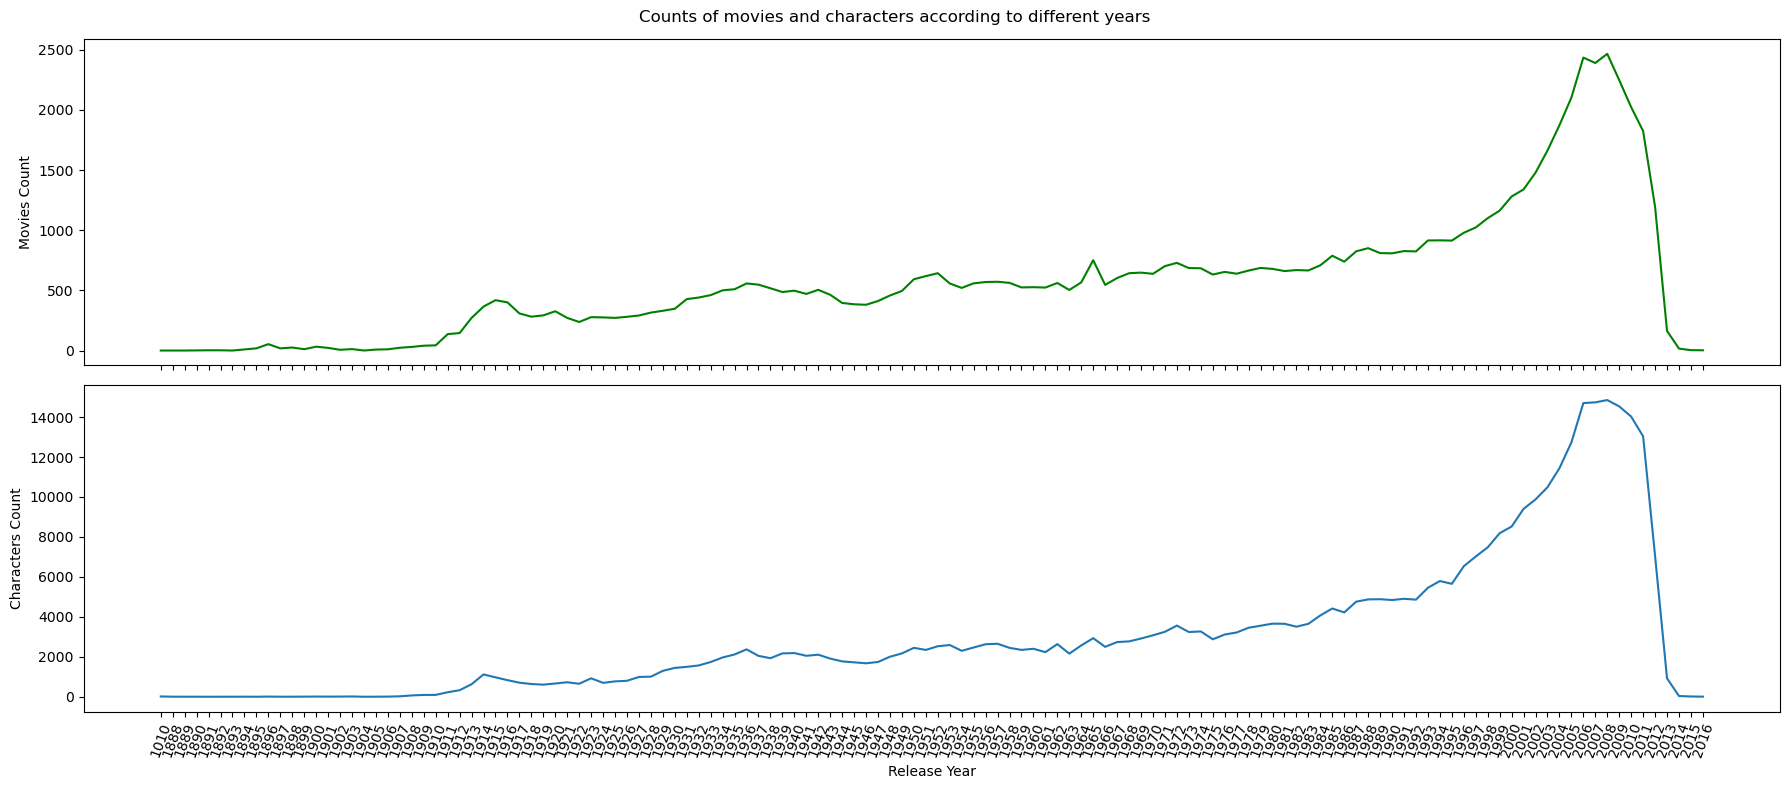

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 8))
fig.suptitle("Counts of movies and characters according to different years")

ax = sns.lineplot(data = movies.release_date.value_counts().sort_index(), ax=axes[0], color='g')
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

ax = sns.lineplot(data = characters.release_date.value_counts().sort_index(), ax=axes[1])
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

axes[0].set(xlabel="Release Year", ylabel="Movies Count")
axes[1].set(xlabel="Release Year", ylabel="Characters Count")
plt.tight_layout()
plt.show()

We can see there's one outlier `1010`. We found that the movie is [*Hunting Season*](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)) which was released in 2010. So it is wrongly reported and we assume the year should be `2010`. We will fix this error now.

Besides, these two distributions are skewed, and we need to carefully sample the dataset when doing temporal analysis. We will handle it in the future.

In [18]:
movies[movies.release_date == '1010']

,wikipedia_id,freebase_id,name,release_date,languages,countries,genres
62836,29666067,/m/0fphzrf,Hunting Season,1010,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [20]:
movies.release_date = movies.release_date.apply(lambda x: '2010' if x == '1010' else x)
movies.release_date = pd.to_datetime(movies.release_date, format="%Y").dt.year
characters.release_date = characters.release_date.apply(lambda x: '2010' if x == '1010' else x)
characters.release_date = pd.to_datetime(characters.release_date, format="%Y").dt.year

### Language, countries, and genres

They are encoded string of dictionaries whose keys are freebase ids. We will only keep the values and put the values in a list. We will also remove "Language" from elements in column `languages`.

In [19]:
movies[["languages", "countries", "genres"]]

,languages,countries,genres
0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...
81736,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [21]:
get_dict_keys = lambda x: np.nan    if x=={} \
                    else  [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [22]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,[German],[Germany],[Drama]


In [23]:
languages_count = pd.Series([x for item in movies.languages for x in item]).value_counts()
print("There are {} languages, but {} of them only have less than 1000 films.".format(len(languages_count), (languages_count<1000).sum()))
print(languages_count)

There are 202 languages, but 190 of them only have less than 1000 films.
English                                 39680
Spanish                                  3532
Hindi                                    3432
French                                   3323
Silent film                              3079
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin                                   1
Pawnee                                      1
Kuna                                        1
Length: 202, dtype: int64


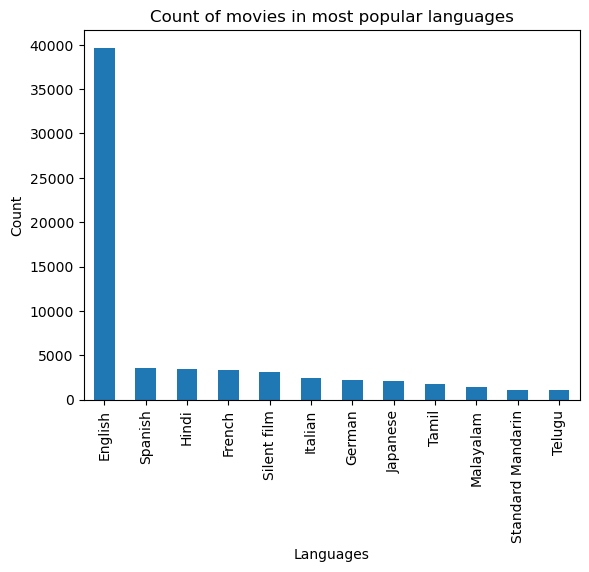

In [24]:
ax = languages_count[languages_count>=1000].plot(kind="bar")
ax.set(xlabel="Languages", ylabel="Count")
ax.set_title("Count of movies in most popular languages")
plt.show()

The distribution is highly skewed. If we want to do gender analysis on movies from different languages, we may only choose a subset of them that have enough movies.

There are silent films in the dataset and we may drop them if we want to do this kind of analysis. Now we choose to keep them.

In [25]:
countries_count = pd.Series([x for item in movies.countries for x in item]).value_counts()
print("There are {} countries/regions, but {} of them only have less than 1000 films.".format(len(countries_count), (countries_count<1000).sum()))
print(countries_count)

There are 146 countries/regions, but 134 of them only have less than 1000 films.
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German                          1
Ukranian SSR                    1
Length: 146, dtype: int64


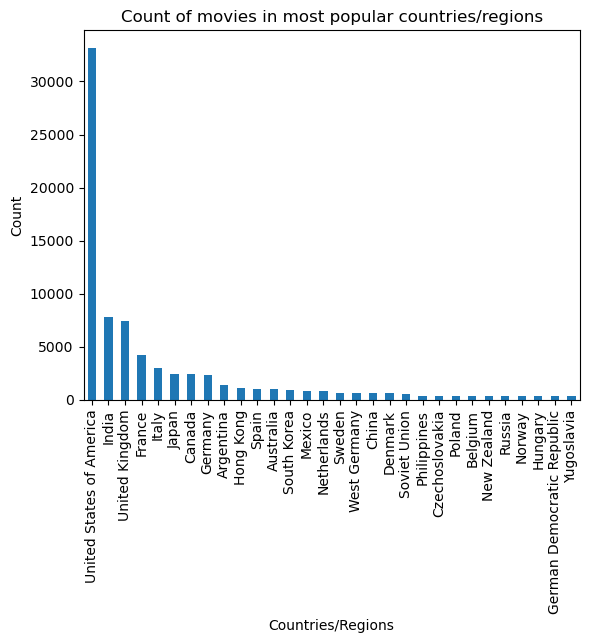

In [26]:
ax = countries_count.iloc[:30].plot(kind="bar")
ax.set(xlabel="Countries/Regions", ylabel="Count")
ax.set_title("Count of movies in most popular countries/regions")
plt.show()

We can see the distribution is also highly skewed. If we want to do gender analysis on movies from different countries/regions, we may only choose a subset of them that have enough movies.

Besides, country/region names are changing (e.g. Germany, West Germany, German Democratic Republic; Soviet Union, Russia). We are still thinking about whether to retain this feature.

## Gender stereotype analysis on movie plot summaries

Now we want to know whether gender stereotypes exist in movie plot summaries. We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe. Then we identify relevant words as first or last two words of noun, verb, or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 15 frequent words for different genders.

### Preprocessing

First we join plot summaries to movies dataset.

In [37]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[[
    "wikipedia_id",
    "release_date",
    "languages",
    "countries",
    "genres",
    "summary"
]]
movies_plots.head()

,wikipedia_id,release_date,languages,countries,genres,summary
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,1983,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


Then we filter movies with plots containing character names in characters dataframe and add these character names in the movies dataframe.

In [36]:
characters_filtered = characters.dropna(subset=['character_name', 'actor_gender'])
characters_filtered.head()

,wikipedia_id,release_date,character_name,actor_gender,actor_name,actor_age
0,975900,2001,Akooshay,F,Wanda De Jesus,42.0
1,975900,2001,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0
2,975900,2001,Desolation Williams,M,Ice Cube,32.0
3,975900,2001,Sgt Jericho Butler,M,Jason Statham,33.0
4,975900,2001,Bashira Kincaid,F,Clea DuVall,23.0


In [29]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [30]:
index = []
name_gender = []
count_gender = {'M': 0, 'F': 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[characters_filtered.wikipedia_id==temp_df.iloc[i].wikipedia_id]
    for word, gender in zip(filtered.character_name.apply(str.lower), filtered.actor_gender):
        if word in temp_df.iloc[i].summary.lower(): # only consider full match. i.e. full character name matches with the plot summary.
            if flag == 0:                           # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender)==len(index)

In [38]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, 'character_names'] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered.head()

,wikipedia_id,release_date,languages,countries,genres,summary,character_names
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",{'desolation williams': 'M'}
1,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",{'morgana': 'F'}
2,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","{'rebecca': 'F', 'nina': 'F'}"
3,171005,1989,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{'henry v': 'M'}
4,77856,1964,[English],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...,"{'george banks': 'M', 'bert': 'M', 'mary poppi..."


In [35]:
print("There are only {} movies left and with {} male characters and {} female characters.".format(
    len(movies_plots_filtered),
    count_gender['M'],
    count_gender['F']
))

There are only 16403 movies left and with 30077 male characters and 15701 female characters.


Now we extract nouns, verbs, and adjectives around male and female character names and put these words in `male_dict` and `female_dict` to calculate the frequency of words. We also count the word frequency of different types of words (noun, verb, adjective).

In [46]:
gender_dict = {
    'M': {'all': {}, 'noun': {}, 'verb': {}, 'adj': {}},
    'F': {'all': {}, 'noun': {}, 'verb': {}, 'adj': {}}
}
pos_filter = [
    'JJ', 'JJR', 'JJS',
    'NN', 'NNS', 'NNP', 'NNPS',
    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
]
pos_filter_dict = {
    'JJ': 'adj', 'JJR': 'adj', 'JJS': 'adj',
    'NN': 'noun', 'NNS': 'noun', 'NNP': 'noun', 'NNPS': 'noun',
    'VB': 'verb', 'VBD': 'verb', 'VBG': 'verb', 'VBN': 'verb', 'VBP': 'verb', 'VBZ': 'verb'
}
window_size = 2     # search two words of {n., adj., v.} before first name and after last name if possible.

In [55]:
# for i in range(len(movies_plots_filtered)):
for i in range(100):  # debugging
    genders = movies_plots_filtered.iloc[i].character_names
    wiki_id = movies_plots_filtered.iloc[i].wikipedia_id
    for character_name in genders:
        gender = genders[character_name]
        assert gender == 'F' or gender == 'M'
        name_list = character_name.split()      # 'yiyang feng' -> ['yiyang', 'feng']
        first_name = name_list[0]
        last_name = name_list[-1]

        tree = ET.parse(summary_path+str(wiki_id)+".xml")   # use corenlp data
        root = tree.getroot()
        pos_list = root.findall(".//*POS")
        word_list = root.findall(".//*lemma")

        idx, length = 0, len(word_list)
        count_head, count_tail = 0, 0
        while idx<length:
            if word_list[idx].text.lower() == first_name and word_list[min(idx+len(name_list)-1, length-1)].text.lower() == last_name:
                head_idx = idx
                tail_idx = idx+len(name_list)-1
                
                # search w1, w2, ... before first name ([w1, w2, ..., 'yiyang', 'feng', ...])
                for pre_idx in range(head_idx-1, -1, -1):
                    if pos_list[pre_idx].text in pos_filter:
                        if word_list[pre_idx].text.lower() not in gender_dict[gender]['all'].keys():
                            gender_dict[gender]['all'][word_list[pre_idx].text.lower()] = 1
                            gender_dict[gender][pos_filter_dict[pos_list[pre_idx].text]][word_list[pre_idx].text.lower()] = 1
                            count_head += 1
                        else:
                            gender_dict[gender]['all'][word_list[pre_idx].text.lower()] += 1
                            gender_dict[gender][pos_filter_dict[pos_list[pre_idx].text]][word_list[pre_idx].text.lower()] += 1
                            count_head += 1
                    
                    if count_head == window_size:
                        break

                    if word_list[pre_idx].text in string.punctuation:   # don't search across sentences!
                        break

                # search v1, v2, ... after last name ([..., 'yiyang', 'feng', v1, v2, ...])
                for nxt_idx in range(tail_idx+1, length):
                    if pos_list[nxt_idx].text in pos_filter:
                        if word_list[nxt_idx].text.lower() not in gender_dict[gender]['all'].keys():
                            gender_dict[gender]['all'][word_list[nxt_idx].text.lower()] = 1
                            gender_dict[gender][pos_filter_dict[pos_list[nxt_idx].text]][word_list[nxt_idx].text.lower()] = 1
                            count_tail += 1
                        else:
                            gender_dict[gender]['all'][word_list[nxt_idx].text.lower()] += 1
                            gender_dict[gender][pos_filter_dict[pos_list[nxt_idx].text]][word_list[nxt_idx].text.lower()] += 1
                            count_tail += 1
                    
                    if count_tail == window_size:
                        break

                    if word_list[nxt_idx].text in string.punctuation:   # don't search across sentences!
                        break

                idx = tail_idx+1

            else:
                idx += 1

### Analysis

We first analyze overall distribution of revelant words of male and female characters. Then we compare log frequencies of different POS of the words (noun, verb, adjective) between men and women.

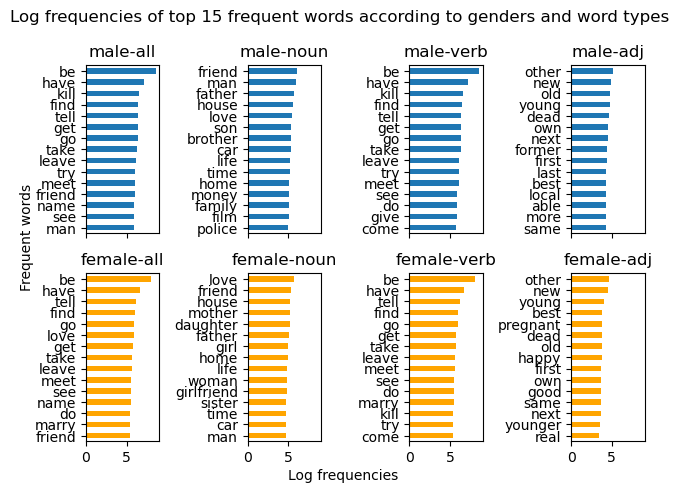

In [137]:
fig, axes = plt.subplots(2, 4, sharex=True)
axes = axes.ravel()
fig.suptitle("Log frequencies of top 15 frequent words according to genders and word types")

for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
    male_words = pd.DataFrame.from_dict(
        gender_dict['M'][word_type],
        orient='index', columns=['count']
    ).sort_values(
        by=['count']
    )[-15:]

    female_words = pd.DataFrame.from_dict(
        gender_dict['F'][word_type],
        orient='index', columns=['count']
    ).sort_values(
        by=['count']
    )[-15:]
    ax = np.log(male_words).plot.barh(ax=axes[idx], legend=False, title="male-{}".format(word_type))
    ax = np.log(female_words).plot.barh(ax=axes[idx+4], color='orange', legend=False, title="female-{}".format(word_type))

fig.text(0.42, 0, "Log frequencies")
fig.text(0, 0.4, "Frequent words", rotation = 90)
plt.tight_layout()
plt.show()

**Analysis**: We found that gender steorotypes do exist in movie plot summaries!

- From the first column of the figure, we can see word "kill" is more related to man characters while "love" and "marry" occur more with woman characters.
- From the second column of the figure, we can see word "police" appears in the top 15 frequent words of male characters but not in female characters.
- From the last column of the figure, we can see word "old" shows up more than "young" for men but the trend is opposite to women.

We can roughly see that males are more related to the words "kill", "police", and "old" while females are associated with the words "love", "marry", "young". This is a quite primitive analysis and somewhat subjective. We need to refine our analysis and find some methods and metrics in the future.

### Future directions

- Use `networkx` to build an entity graph by linking male and female characters to relevant words. Visualize which words are unique to males and females and which are common.
- Separate the factors of time, genres, countries, languages, and POS (n., adj., v.).
- Explore ways to analyze gender steorotypes from word frequencies.